# Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
iris = datasets.load_iris()

X = iris['data'][:, (2, 3)]  # petal length, petal width
y = iris['target']
X_with_bias = np.c_[np.ones([len(X), 1]), X] # concatenation

In [3]:
np.random.seed(2042)

## Split training set, validation set and test set

In [4]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(test_ratio * total_size)
validation_size = int(validation_ratio * total_size)
training_size = total_size - test_size - validation_size

random_indices = np.random.permutation(total_size)

X_training = X_with_bias[random_indices[:training_size]]
y_training = y[random_indices[:training_size]]
X_validation = X_with_bias[random_indices[training_size:-test_size]]
y_validation = y[random_indices[training_size:-test_size]]
X_test = X_with_bias[random_indices[-test_size:]]
y_test = y[random_indices[-test_size:]]

## Define a one-hot matrix

In [5]:
def to_one_hot(y):
    class_nb = max(y) + 1
    matrix_rownb = len(y)
    y_one_hot = np.zeros((matrix_rownb, class_nb))
    y_one_hot[np.arange(matrix_rownb), y] = 1
    
    return y_one_hot

Converting the vector of class indices into a matrix containing a one-hot vector for each instance

In [6]:
y_training_one_hot = to_one_hot(y_training)
y_validation_one_hot = to_one_hot(y_validation)
y_test_one_hot = to_one_hot(y_test)

## Define softmax function

In [7]:
%%latex
\begin{align}
\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
\end{align}

<IPython.core.display.Latex object>

In [8]:
def softmax(each_class_score):
    exps = np.exp(each_class_score)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    
    return exps / exp_sums

In [9]:
nb_inputs = X_training.shape[1] # 2 features + 1 bias term
nb_outputs = len(np.unique(y_training)) # 3 iris classes

## Train model

Cross entropy cost function

In [10]:
%%latex
\begin{align}
J(\mathbf{\Theta}) = \dfrac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
\end{align}

<IPython.core.display.Latex object>

Cross entropy gradient vector for class k

In [11]:
%%latex
\begin{align}
\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
\end{align}

<IPython.core.display.Latex object>

**/ ! \** Note that $\log (\hat{p}_{k}^{(i)})$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log (\hat{p}_{k}^{(i)})$ to avoid getting `nan` values.

Let's train Softmax model:

In [12]:
eta = 0.01 # learning rate
nb_iterations = 5001
m = len(X_training)
epsilon = 1e-7

theta = np.random.randn(nb_inputs, nb_outputs)

for iteration in range(nb_iterations):
    logits = X_training.dot(theta)
    y_proba = softmax(logits)
    loss = -np.mean(np.sum(y_training_one_hot * np.log(y_proba + epsilon), axis=1))
    error = y_proba - y_training_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_training.T.dot(error)
    theta = theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


In [13]:
theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [14]:
logits_validation = X_validation.dot(theta)
y_validation_proba = softmax(logits_validation)
y_validation_predict = np.argmax(y_validation_proba, axis=1)

accuracy_score = np.mean(y_validation_predict == y_validation)
accuracy_score

0.9666666666666667

Now, let's add $\\l_2$ regularization:

In [15]:
eta = 0.1
n_iterations = 5001
m = len(X_training)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

theta = np.random.randn(nb_inputs, nb_outputs)

for iteration in range(n_iterations):
    logits = X_training.dot(theta)
    y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_training_one_hot * np.log(y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = y_proba - y_training_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_training.T.dot(error) + np.r_[np.zeros([1, nb_outputs]), alpha * theta[1:]]
    theta = theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075476
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.4890351244397859
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


In [16]:
logits_validation = X_validation.dot(theta)
y_validation_proba = softmax(logits_validation)
y_validation_predict = np.argmax(y_validation_proba, axis=1)

accuracy_score = np.mean(y_validation_predict == y_validation)
accuracy_score

1.0

Let's add early stopping: for this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [17]:
eta = 0.1
n_iterations = 5001
m = len(X_training)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

theta = np.random.randn(nb_inputs, nb_outputs)

for iteration in range(n_iterations):
    logits = X_training.dot(theta)
    y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_training_one_hot * np.log(y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = y_proba - y_training_one_hot
    
    gradients = 1/m * X_training.T.dot(error) + np.r_[np.zeros([1, nb_outputs]), alpha * theta[1:]]
    theta = theta - eta * gradients
    
    logits = X_validation.dot(theta)
    y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_validation_one_hot * np.log(y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, 'early stopping !')
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285545
2500 0.5325946767399382
2765 0.5325460966791898
2766 0.5325460971327978 early stopping !


In [18]:
logits_validation = X_validation.dot(theta)
y_validation_proba = softmax(logits_validation)
y_validation_predict = np.argmax(y_validation_proba, axis=1)

accuracy_score = np.mean(y_validation_predict == y_validation)
accuracy_score

1.0

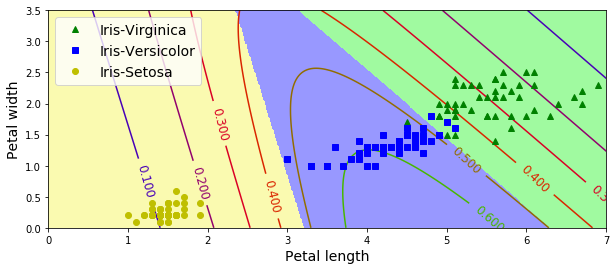

In [19]:
# Inspired by https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

## Test model

Now, let's measure the final model's accuracy with test set:

In [20]:
logits_test = X_test.dot(theta)
y_test_proba = softmax(logits_test)
y_test_predict = np.argmax(y_test_proba, axis=1)

accuracy_score = np.mean(y_test_predict == y_test)
accuracy_score

0.9333333333333333